<a href="https://colab.research.google.com/github/artemkurylev/Outlier_Detection/blob/master/AML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget -O data.csv https://www.openml.org/data/get_csv/52214/phpn1jVwe

--2020-04-03 08:34:37--  https://www.openml.org/data/get_csv/52214/phpn1jVwe
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘data.csv’

data.csv                [   <=>              ] 808.56K  1.50MB/s    in 0.5s    

2020-04-03 08:34:38 (1.50 MB/s) - ‘data.csv’ saved [827961]



In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
from torch.functional import F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
%matplotlib inline

In [0]:
df = pd.read_csv("data.csv")

In [57]:
df.head()

,attr1,attr2,attr3,attr4,attr5,attr6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr1   11183 non-null  float64
 1   attr2   11183 non-null  float64
 2   attr3   11183 non-null  float64
 3   attr4   11183 non-null  float64
 4   attr5   11183 non-null  float64
 5   attr6   11183 non-null  float64
 6   class   11183 non-null  object 
dtypes: float64(6), object(1)
memory usage: 611.7+ KB


In [59]:
df.describe()

,attr1,attr2,attr3,attr4,attr5,attr6
count,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04
mean,1.096535e-10,1.297595e-09,5.698113e-10,-2.435705e-09,-1.120680e-09,1.459483e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
25%,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
50%,-1.085769e-01,-3.949941e-01,-2.309790e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
75%,3.139489e-01,-7.649473e-02,2.198366e-01,8.202077e-01,-3.778657e-01,1.016613e+00
max,3.150844e+01,5.085849e+00,2.947777e+01,9.591164e+00,2.361712e+01,1.949027e+00


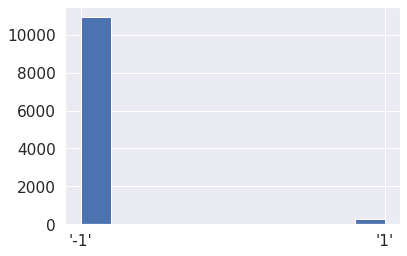

In [60]:
df['class'].hist()

In [61]:
df['target'] = df['class'].apply(lambda x : 0 if x == "'-1'" else 1)
df.head()

,attr1,attr2,attr3,attr4,attr5,attr6,class,target
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1',0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1',0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1',0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1',0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1',0


In [0]:
X = df[['attr1','attr2','attr3','attr4','attr5','attr6']]
Y = df[['target']]

In [63]:
Y['target'].unique()

array([0, 1])

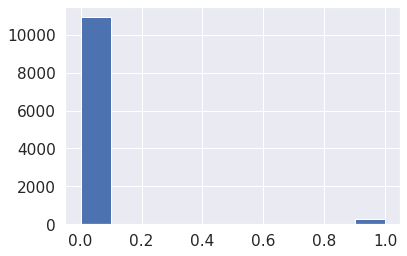

In [64]:
Y['target'].hist()

In [65]:
from collections import Counter
Counter(Y['target'])

Counter({0: 10923, 1: 260})

#### Normalization


In [0]:
x = X.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

#### Oversampling

In [71]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train.to_numpy().ravel())
X_resampled, y_resampled = shuffle(X_resampled,y_resampled)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
train_dataset = TensorDataset(torch.Tensor(X_resampled), torch.Tensor(y_resampled.reshape(y_resampled.shape[0],-1)))
test_dataset = TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(y_test.to_numpy()))

In [0]:
batch_size = 10

In [0]:
data_loader = torch.utils.data.DataLoader(train_dataset,batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

In [0]:
class Baseline(nn.Module):
  def __init__(self):
    super(Baseline,self).__init__()
    self.fc1 = nn.Sequential(
        nn.Linear(6,128),
        nn.LeakyReLU(),
        nn.Linear(128,1024),
        nn.LeakyReLU(),
        nn.Linear(1024,1024),
        nn.LeakyReLU(),
        nn.Linear(1024,1)
    )
  def forward(self,x):
    out = self.fc1(x)
    #out = torch.sigmoid(out)
    
    return out

#### Cuda

In [0]:
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if cuda else 'cpu'

#### Weight initialization

In [0]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

In [104]:
baseline = Baseline()
if cuda:
  baseline.cuda()
baseline.fc1.apply(init_weights)

Sequential(
  (0): Linear(in_features=6, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=1024, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=1024, out_features=1, bias=True)
)

In [0]:
lr = 0.01
optimizer = optim.Adam(baseline.parameters(), lr=lr)

In [125]:
n_epochs = 25
n_print = 100

for epoch in range(n_epochs):
  total, correct = 0, 0
  baseline.train()
  criterion = nn.BCEWithLogitsLoss()
  for i, (data,target) in enumerate(data_loader):
    optimizer.zero_grad()
    output = baseline(data.to(device))
    loss =  criterion(output.float(),target.to(device))
    loss.backward()

    # Compute train accuracy
    _, predicted = torch.max(output.data, 1)
    batch_total = target.size(0)
    total += batch_total
    #print(output.data == target.data)
    batch_correct = (torch.round(torch.sigmoid(output.data)) == target.to(device).data).sum()
    correct += batch_correct
    optimizer.step()

    if (i + 1) % n_print == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
            % (epoch + 1, n_epochs, i + 1, len(train_dataset) // batch_size, loss.item()))
  print("correct: {}\ntotal: {}".format(correct, total))
  print("Accuracy on Epoch[{}/{}]: {}%".format(epoch + 1, n_epochs, 100* correct/total ))


Epoch [1/25], Step [100/1747], Loss: 0.5848
Epoch [1/25], Step [200/1747], Loss: 0.0336
Epoch [1/25], Step [300/1747], Loss: 0.3155
Epoch [1/25], Step [400/1747], Loss: 0.1086
Epoch [1/25], Step [500/1747], Loss: 0.0352
Epoch [1/25], Step [600/1747], Loss: 0.0598
Epoch [1/25], Step [700/1747], Loss: 0.0848
Epoch [1/25], Step [800/1747], Loss: 0.0661
Epoch [1/25], Step [900/1747], Loss: 0.0522
Epoch [1/25], Step [1000/1747], Loss: 0.5603
Epoch [1/25], Step [1100/1747], Loss: 0.0274
Epoch [1/25], Step [1200/1747], Loss: 0.3574
Epoch [1/25], Step [1300/1747], Loss: 0.1292
Epoch [1/25], Step [1400/1747], Loss: 0.1849
Epoch [1/25], Step [1500/1747], Loss: 0.4459
Epoch [1/25], Step [1600/1747], Loss: 0.0638
Epoch [1/25], Step [1700/1747], Loss: 0.2908
correct: 15692
total: 17476
Accuracy on Epoch[1/25]: 89%
Epoch [2/25], Step [100/1747], Loss: 0.6368
Epoch [2/25], Step [200/1747], Loss: 0.0497
Epoch [2/25], Step [300/1747], Loss: 0.2981
Epoch [2/25], Step [400/1747], Loss: 0.1466
Epoch [2/25

In [133]:
correct = 0
total = 0
all_target = None
all_output = None
for data, target in test_loader:
  
  outputs = baseline(data.to(device))
  total += target.size(0)
  correct += (F.log_softmax(outputs).data == target.to(device).data).sum()
  if all_target is None:
    all_target = target.data.numpy().reshape(target.data.shape[0],-1)
    all_output = torch.round(torch.sigmoid(outputs)).cpu().data.numpy().reshape(target.data.shape[0],-1)
  else:
    all_target = np.concatenate((all_target,target.data.numpy().reshape(target.data.shape[0],-1)))
    all_output = np.concatenate((all_output,torch.round(torch.sigmoid(outputs)).cpu().data.numpy().reshape(target.data.shape[0],-1)))
print('Test Accuracy of the model on the test: %d %%' % (100 * correct / total))

Test Accuracy of the model on the test: 97 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


#### Confusion Matrix

In [134]:
all_output

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

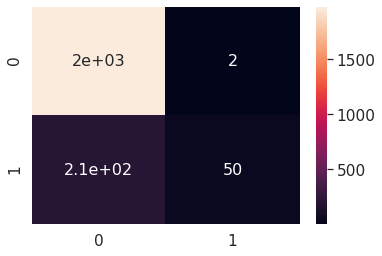

In [135]:
cm = confusion_matrix(all_output, all_target)
df_cm = pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

#### CLassification report

In [136]:
print(classification_report(all_target, all_output))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      2185
         1.0       0.19      0.96      0.32        52

    accuracy                           0.91      2237
   macro avg       0.60      0.93      0.64      2237
weighted avg       0.98      0.91      0.93      2237

